# COMP30760 Assignment 1 Sample - Task 2

In this assignment our goal in this work is to collect a large amount of data from the Ticket Master open web API, with a special focus on specifics like Events, Venues, Segments, Tickets and other important details related to the United States.



***Task 2 is Data Preparation and Analysis***, and that is the focus of this notebook. The JSON datasets we collected in Task 1 serve as our data source, and we will use that dataset to carry out the analytical processes.


In [1]:
# Importing all libraries for the data analysis and visualisation 
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from datetime import date
import seaborn as sns
import folium
import re
from tabulate import tabulate
from wordcloud import WordCloud

In [2]:
# Load the dataframe in the given path 
rawdata = pd.read_csv('raw/raw_Event_Data.csv')
# rawdata.head()

# Data Cleaning 

## The following Data Cleaning Operation has been performed on Dataset -

Here I have created new dataframe for storing the specific columns for datamanipulation that helps me to calculate the specific needs and making this data analysis and processing more efficient and effective way.

### 1. Remove the unnessesary column and Load only Relevent column for analysis 

1. Creating a new datframe and and copy selected column into it. 

In [3]:
columns_to_select = [
    'Event ID','Event Name', 'Event Date', 'Venue', 'Ticket Limit',  'Ticket Limit Info', 
    'Segment', 'Genre', 'Standard Price Min', 'Standard Price Max','Product Name', 
    'Product Type', 'City', 'State', 'Box Office Info','Open hours', 'will Call Details','Parking Info',
    'Longitude','Latitude'
]
data = rawdata[columns_to_select].copy()

###  2: Handling Missing Values
1. Fill missing values in 'Ticket Limit' column with the maximum limit of 50
2. Fill missing values in  columns with the Not Available 

In [4]:
data['Ticket Limit'] = pd.to_numeric(data['Ticket Limit'].replace('Not Available', 50).fillna(50))
data['Ticket Limit Info'].fillna('Not Available', inplace=True)
data['Product Name'].fillna("Not Available", inplace=True)
data['Product Type'].fillna("Not Available", inplace=True)
data['Parking Info'].fillna("Not Available", inplace=True)


###   3: Data Type Conversion
1. Here I Convert 'Event Date' to datetime format 

In [5]:
data['Event Date'] = pd.to_datetime(data['Event Date'])

###  4: Renaming Columns
1. Renaming columns with more meaningful names which improves clarity in my dataset

In [6]:
data.rename(columns={'Box Office Info': 'Box Office Information'}, inplace=True)

### 5: Creating Column Average Price 
1. Calculate average price from 'Standard Price Min' and 'Standard Price Max' and storing that value in new column to understand the data later. 

In [7]:
data['Average Price'] = (data['Standard Price Min'] + data['Standard Price Max']) / 2

### 6: Extract phone numbers from 'Box Office Info' column in specific format 

In [8]:
data['Box Office Phone'] = data['Box Office Information'].str.extract(r'(\(\d{3}\) \d{3}-\d{4}|\d{3}-\d{3}-\d{4})')
data['Box Office Phone'] = data['Box Office Phone'].str.replace(r'[\(\) ]', '', regex=True)

### 7: Filling "Not Available" 

1. There are some of the fields where there are some missing values. I filled those points whith Not Available in the required columns  

In [9]:
data['Box Office Phone'].fillna('Not Available', inplace=True)
data['Box Office Information'].fillna('Not Available', inplace=True)
data['Open hours'].fillna('Not Available', inplace=True)
data['will Call Details'].fillna('Not Available', inplace=True)


### 8. Extra Spacing

1. I removed the extra spaces in the city and state column 

In [10]:
data['City'] = data['City'].str.split('-').str[0].str.strip()  
data['State'] = data['State'].str.strip()

In [11]:
clean_csv_path = Path('data/cleandataframe.csv')
data.to_csv(clean_csv_path, index=False)
print(f"1000 records have been added to data directory{clean_csv_path}.")

1000 records have been added to data directorydata/cleandataframe.csv.


# Data Visualisation 

## 1 Event : 

### 1.1 . Visualise the distribution of events by name      - Count Plot

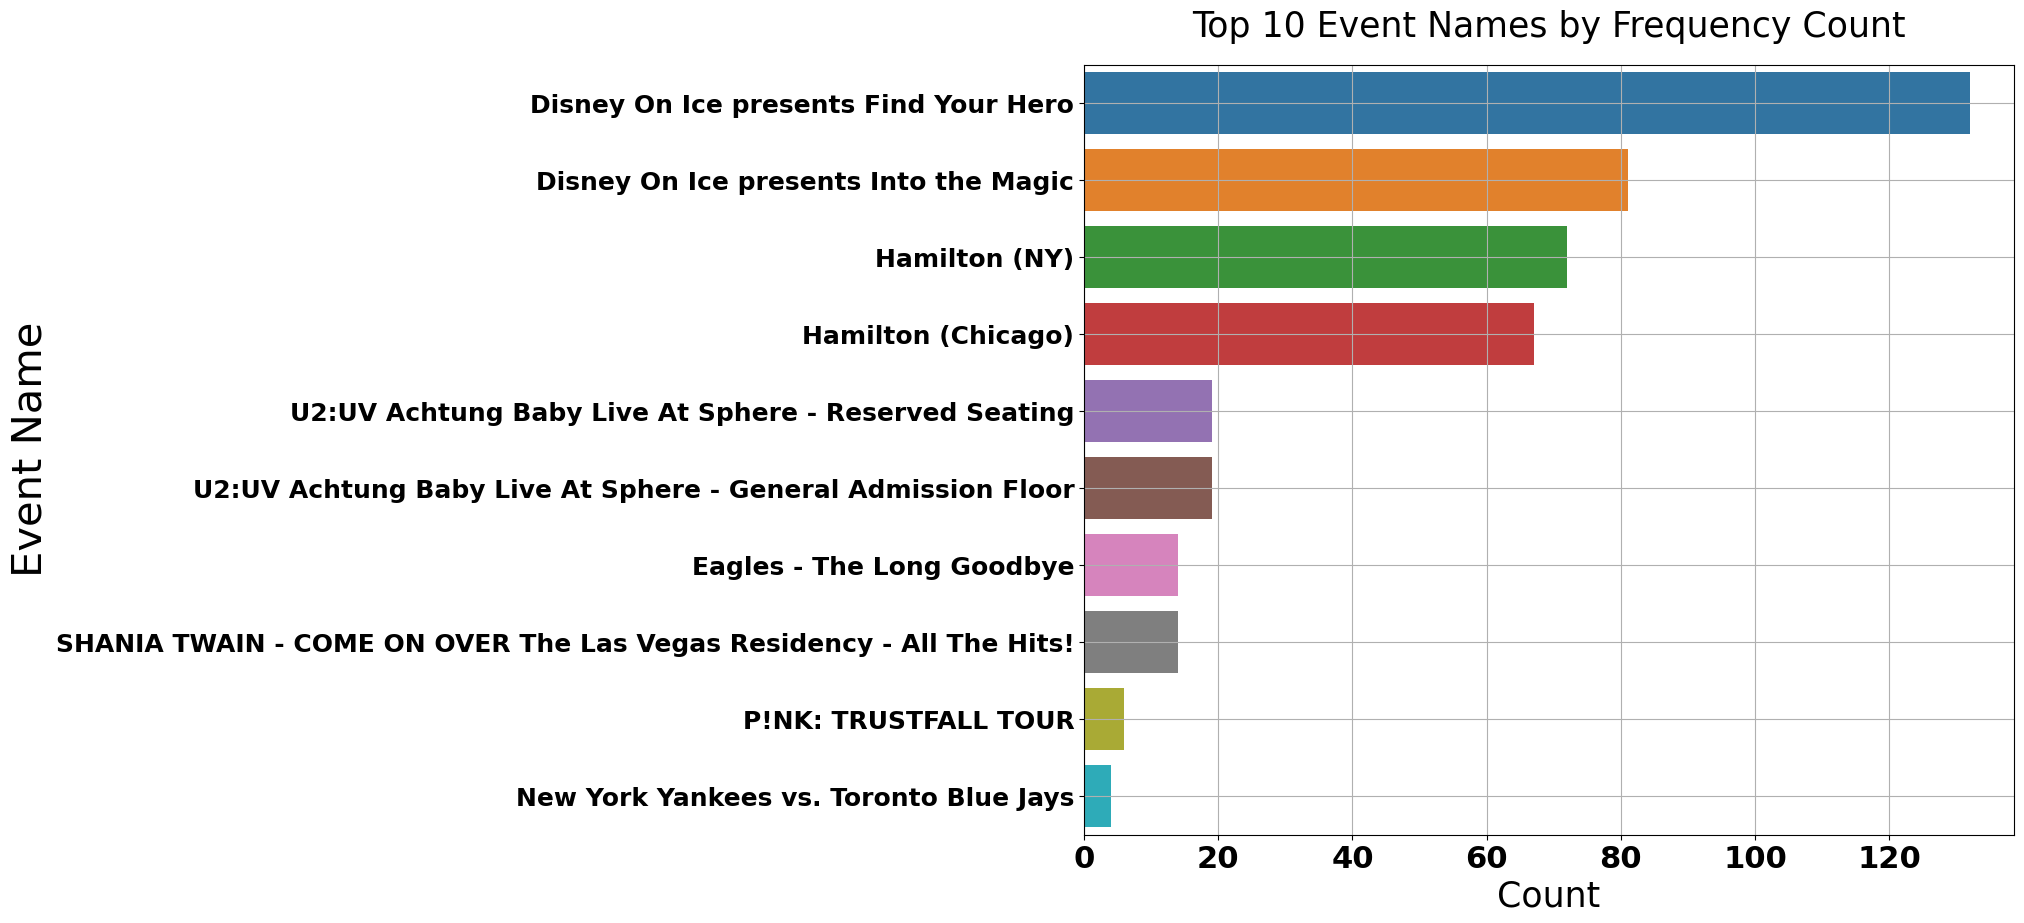

In [12]:
plt.figure(figsize=(12, 10))
sns.countplot(data=data, y='Event Name', order=data['Event Name'].value_counts().iloc[:10].index)
plt.title("Top 10 Event Names by Frequency Count", fontsize=25, pad=20)
plt.xlabel("Count", fontsize=25)
plt.ylabel("Event Name", fontsize=30)
plt.xticks(fontsize=22, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.grid()
plt.show()

***Summary:***

Firstly, we look at the Events and their frequency. This horizontal Count Plot shows the top ten events and their names with the number of event occurences. 
Given that it provides insights into the preferences and demand for particular events. 

### 1.2. Create a  plot for price ranges     - Box Plot 

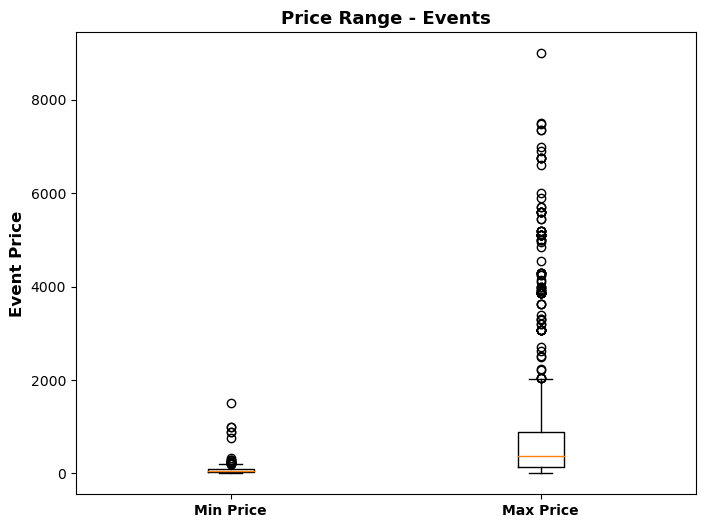

In [13]:
plt.figure(figsize=(8, 6))
plt.boxplot([data['Standard Price Min'], data['Standard Price Max']], labels=['Min Price', 'Max Price'])
plt.ylabel('Event Price',fontsize=12, fontweight='bold')
plt.title('Price Range - Events',fontsize=13, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.show()

***Summary:***

The price ranges for the events in the dataset are shown in a box plot. It helps in getting a grasp of the range and distribution of ticket costs for the events in ticket master dataset, as well as the lowest and highest prices. There are some outliers in the grph to visualise the some prices are very high from 2000. 

### 1.3. Group events by date and count   -  Time Series Plot 

In [14]:
events_by_date = data.groupby('Event Date').size().reset_index(name='Event Count')
fig = px.line(events_by_date, x='Event Date', y='Event Count', labels={'Event Count': 'Number of Events'})
fig.update_layout(title='Distribution of Events Over Time', xaxis_title='Event Date', yaxis_title='Number of Events')
fig.show()

Distribution of Events Over Time (Event Date):

The event distribution throughout time is displayed in this time series plot. It keeps an eye on the number of events that happen on each date and plots that number on the y-axis. Here we see that,  high and low activity times and trends in event frequency with the help of this graph.

***Summary:***
1. Here I used a Time Series plot to visualize the distribution of events over time to identify trends or seasonality. 
2. We'll group events by date and count the number of events for each date.

### 1.4. Filter events that occur in the future   -  Bar Plot 

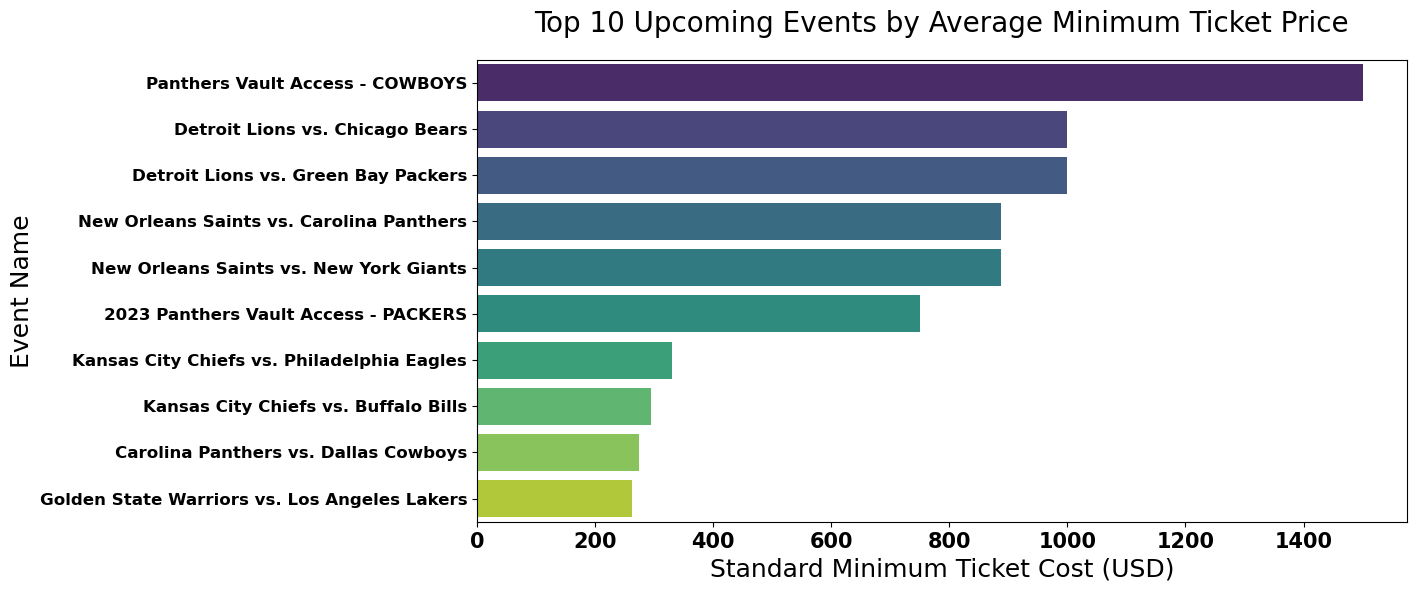

In [15]:
upcoming_events = data[data['Event Date'] > pd.Timestamp(date.today())]
upcoming_event_price_trends = upcoming_events.groupby('Event Name')['Standard Price Min'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=upcoming_event_price_trends.nlargest(10, 'Standard Price Min'),
            x='Standard Price Min',
            y='Event Name',
            palette='viridis')
plt.xlabel('Standard Minimum Ticket Cost (USD)', fontsize=18)
plt.ylabel('Event Name', fontsize=18)
plt.title('Top 10 Upcoming Events by Average Minimum Ticket Price',fontsize=20, pad=20)
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

The above bar plot shows the top 10 available events with the highest average minimum ticket prices after filtering events in a dataset and calculating the average minimum price for each event. It helps in locating the dataset's most expensive future occurrences.

***Summary:*** 
1. This Bar Graph calculate average minimum ticket price for upcoming events 
2. Each Plot for the top 10 upcoming events according to price

Here We easily seen that I top 10 events range in price from 200  to 1400 and more. 


### 1.5. Event Date vs. Event Count     -  Count Plot

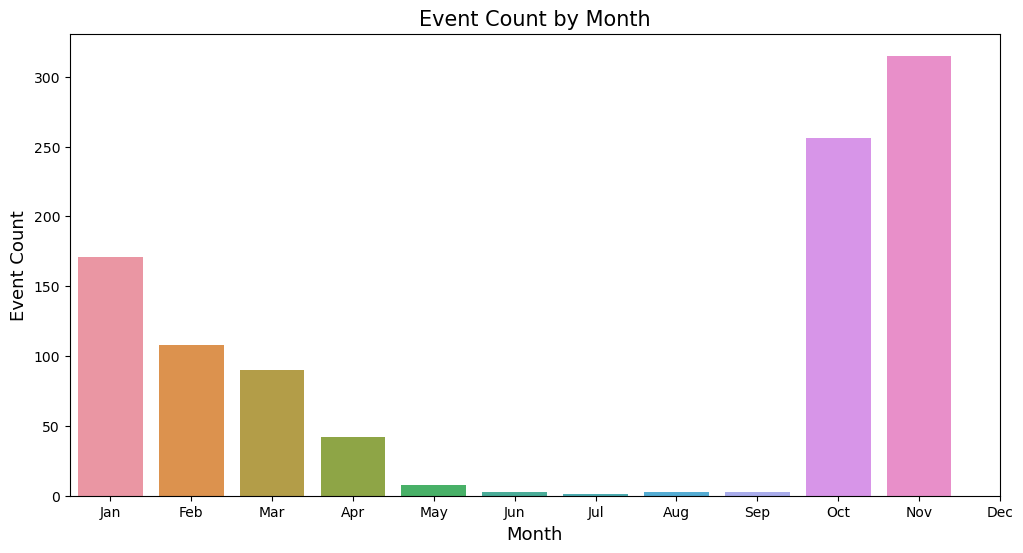

In [16]:
data['Event Date'] = pd.to_datetime(data['Event Date'])
data['Month'] = data['Event Date'].dt.month
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Month')
plt.title("Event Count by Month", fontsize=15)
plt.xlabel("Month", fontsize=13)
plt.ylabel('Event Count',fontsize=13)
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

The above count plot that displays the distribution of occurrences by month by analyzing event data by date. 

***Summaryy:***

1. It takes the 'Event Date' column, formats it in datetime, extracts the month, and uses a count plot to show the number of events for each month. 

2. The distribution of events throughout the year is made clearer by analysing this figure.

This graph readily provides us with information regarding the highest number of incidents in November and the lowest number in July. 

### 1.6. Visualize the distribution of events by genre   -  Count Plot 

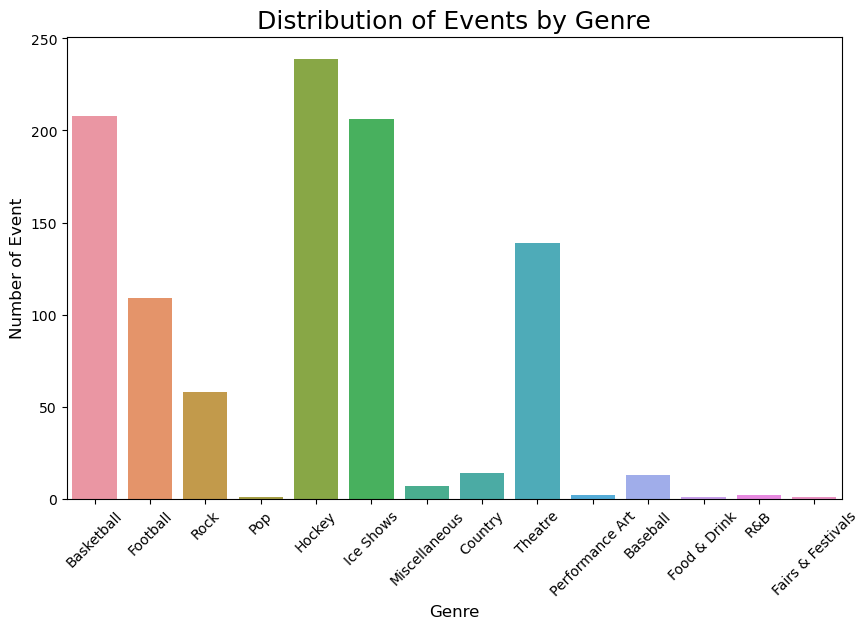

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Genre')
plt.title("Distribution of Events by Genre", fontsize=18)
plt.xticks(rotation=45)
plt.xlabel("Genre",fontsize=12)
plt.ylabel("Number of Event",fontsize=12)
plt.show()

This count plot to show how events are distributed according to genre. 

1. A genre is represented by each bar in the plot, and the height of the bar shows how many events fall into that genre. 

2. With genre names on the x-axis and event Event counts on the y-axis, it's an easy way to identify which genres are most prevalent in the dataset.

***Summary:***

The storyline helps in determining which event categories are most common. We can see that Hockey Event Genre is highest count compare to others. 

### 1.7. Count the number of events in each season for each genre   - Stacked Bar Chart 

In [18]:
data['Event Date'] = pd.to_datetime(data['Event Date'])
data['Season'] = data['Event Date'].dt.month.map({
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
}) 
season_genre_counts = data.groupby(['Season', 'Genre']).size().unstack(fill_value=0)
fig = px.bar(season_genre_counts, x=season_genre_counts.index, y=season_genre_counts.columns,
             title="Distribution of Events by Genre and Season",
             labels={'x': 'Season', 'y': 'Number of Events', 'color': 'Genre'},
             category_orders={'x': ['Winter', 'Spring', 'Summer', 'Fall']},
             barmode='relative')
fig.update_layout(xaxis_title='Season', yaxis_title='Number of Events', legend_title='Genre')
fig.show()

This Stacked bar chart maintains track of how many events there are in each genre throughout multiple seasons. 

***Summary***

1. It counts the events in each genre for each season after first classifying events by season (e.g., Winter, Spring) based on their times. 

2. A grouped stacked bar chart showing the variation in the number of events by season and genre is created from the resulting data. 

The graphic help in identifying yearly trends and patterns in the distribution of events. We can see that number of events are highest in Winter, on the other hand events happening in summer are ths least. 

### 1.8. Count the number of events for each Segment    - Bar Graph and Pie Chart

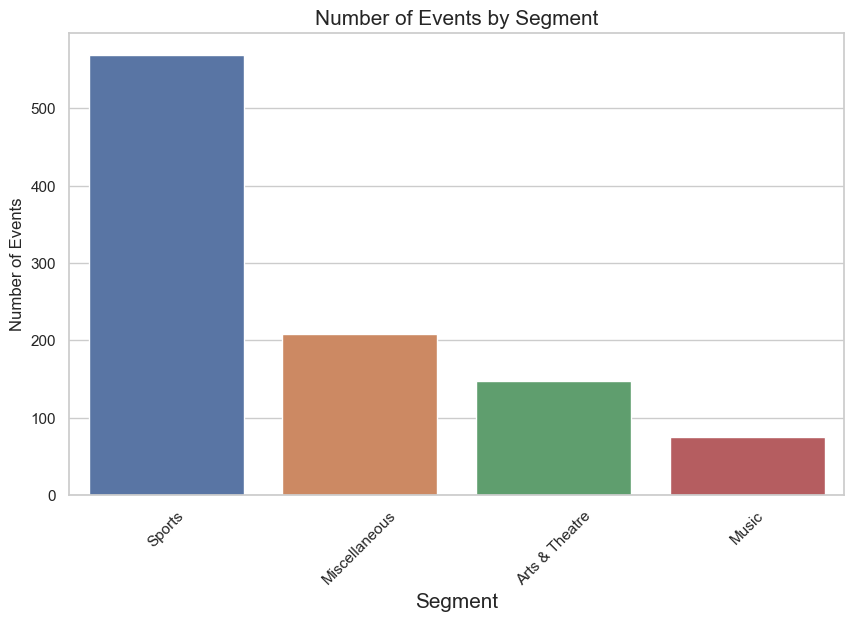

In [19]:
genre_counts = data['Segment'].value_counts()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Segment', fontsize=15)
plt.ylabel('Number of Events')
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Number of Events by Segment',fontsize=15)
plt.xticks(rotation=45)
plt.show()


genre_counts = data['Segment'].value_counts().reset_index()
genre_counts.columns = ['Segment', 'Count']
fig = px.pie(genre_counts, names='Segment', values='Count', 
             title="Events by Segment",
             hole=0.4,  
             labels={'Segment': 'Segment'},
             template="plotly",  
             )
fig.update_traces(textinfo='percent+label', pull=[0.1, 0.1, 0.1], textfont_size=12, textposition='inside',
                  marker=dict(colors=px.colors.qualitative.Plotly, line=dict(color='white', width=2)))
fig.show()

Bar Graph: The above figure is used to compare event counts across segments by counting and displaying the number of occurrences in each segment using bars.

Pie Chart: It shows the percentage of occurrences in each section in relation to the total by counting and displaying events as slices of a pie.

***Summary:***

The bar graph for comparisons and the pie chart for proportions are two distinct ways that both graphs help in the visualization of database data.


This makes the majority of the sports events easier to understand. The music is low as compared to Sports Segment. 

### 1.9. Group events by state and count the number of events for each state  - Bar Chart

In [20]:
state_event_counts = data.groupby('State')['Event ID'].count().reset_index()
fig = px.bar(state_event_counts, 
             x='State', 
             y='Event ID',
             title="Bar Chart of Event Distribution by State",
             labels={'Event ID': 'Number of Events'},
             color='State')
fig.show()

Here we see that each state and groups of events according to the state in which they occur. 

1. This bar chart that shows how events are distributed among the various states. 

2. Every bar depicts a state, and the height of the bar indicates how many occurrences there are in that state.

***Summary***

Event distribution across several states or regions, this visualization sheds light on the areas of the dataset where occurrences are most common. Easily we understand that most of the events are occured in New York comparitively others. 

### 1.10. Event Ticket prices    -  Histogram 

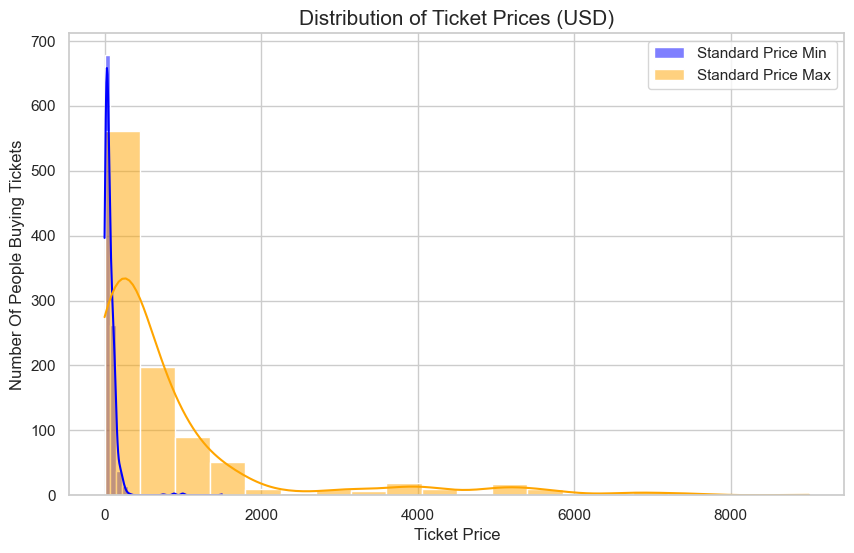

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Standard Price Min', kde=True, label='Standard Price Min',color='blue', bins=20)
sns.histplot(data=data, x='Standard Price Max', kde=True, label='Standard Price Max',color='orange', bins=20)
plt.title("Distribution of Ticket Prices (USD)", fontsize=15)
plt.xlabel("Ticket Price")
plt.ylabel("Number Of People Buying Tickets")
plt.legend()
plt.show()

The above histogram represent the lowest and maximum prices, the graph displays the distribution of event ticket prices.

Kernel Density Estimation (KDE): KDE is represented by the smooth curves in the histogram. It shows underlying patterns in ticket prices and allows a more dynamic visualization of the data distribution.

***Summary:***

Here we can see that data is segmented into 20 bins using binning in order to show a range of ticket prices in more detail. This makes it easier to identify pricing trends and differences in ticket prices for the number of event. 

### 1.11. Group events by venue and count the number of events at each venue  - Area chart

In [22]:
venue_event_counts = data['Venue'].value_counts()
sorted_venues = venue_event_counts.sort_values(ascending=False)
top_10_venues = sorted_venues[:10]
fig = px.area(x=top_10_venues.index, y=top_10_venues.values, title="Top 10 Venues with the Most Events",
              labels={'x': 'Venue', 'y': 'Number of Events'})
fig.update_traces(fill='tozeroy', line=dict(width=0.5, color='darkblue'))
fig.update_xaxes(tickangle=45)
fig.show()

Area Chart: 

The venue names are displayed on the x-axis, and the number of events is displayed on the y-axis, providing a visual representation of these top venues. With respect to popular event locations within the dataset, the chart helps in identifying the venues that hold the most events.

***Summary:***

1. Here we anlyse number of events at each location and using an area chart to provide the top 10 venues with the most events.

2. The popularity of events at various locations will be clearly represented visually via the Area chart. 

3. Here we see that Richard Theater has the maximum number of events as compared to others. 

### 1.12. Calculate the count of events with each contact method   - Pie Chart 

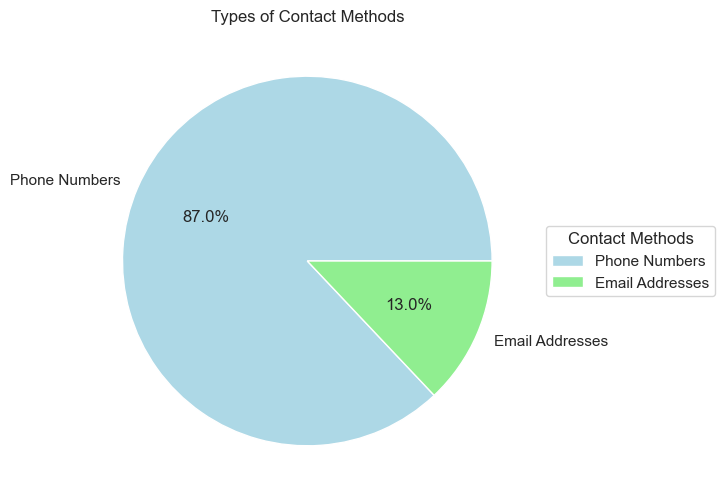

In [23]:
data['Box Office Information'] = data['Box Office Information'].str.replace(r'\s+', ' ', regex=True)
data['Phone Numbers'] = data['Box Office Information'].str.extract(r'(\d{3}-\d{3}-\d{4})')
data['Email Addresses'] = data['Box Office Information'].str.extract(r'([\w\.-]+@[\w\.-]+)')
contact_methods = ['Phone Numbers', 'Email Addresses']
for method in contact_methods:
    contact_count = data[method].count()
contact_counts = data[contact_methods]
contact_counts = data[contact_methods].count()
colors = ['lightblue', 'lightgreen']
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(contact_counts, labels=contact_counts.index, autopct='%1.1f%%', colors=colors)
ax.legend(wedges, contact_counts.index, title="Contact Methods", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("Types of Contact Methods")
plt.show()

***Summary:***

This above Pie chart shows the distribution of events by Two contact methods. 
After extracting phone numbers and email addresses from event data. It makes it easier to see how events in the dataset can be contacted by phone or email.

Most of the Percentage on the 86.9% in the Phone Numbers and 13.1% Email Address for the contact methods.  

### 1.13. Showing the USA details of events,venues and their gerne - Folium Map 

In [24]:
map_center = [39.8283, -98.5795]
m = folium.Map(location=map_center, zoom_start=4)
event_color_mapping = {
    'Music': 'purple',
    'Sports': 'green',
    'Miscellaneous': 'orange',
    'Arts & Theatre': 'violet',

}
color_combinations = {
    ('Music', 'Pop'): 'purple',
    ('Music', 'Rock'): 'lightblue',
    ('Sports', 'Basketball'): 'darkorange',
    ('Miscellaneous', 'Comedy'): 'pink',
    ('Arts & Theatre', 'Classical'): 'lightgreen',
   
}
for index, row in data.iterrows():
    event_name = row['Event Name']
    venue_name = row['Venue']
    venue_lat = row['Latitude']
    venue_lon = row['Longitude']
    event_type = row['Segment']  
    genre = row['Genre']
    popup_msg = f"<b>Event Name:</b> {event_name}<br><b>Venue Name:</b> {venue_name}<br><b>Genre:</b> {genre}"
    marker_color = color_combinations.get((event_type, genre), event_color_mapping.get(event_type, 'gray'))
    folium.Marker([venue_lat, venue_lon], popup=popup_msg, icon=folium.Icon(color=marker_color)).add_to(m)
m.save('colorful_event_locations_map.html')


/var/folders/0s/8tbml_jn793dhhj1b4wgksl80000gn/T/ipykernel_18975/592312813.py:27: UserWarning:

color argument of Icon should be one of: {'white', 'red', 'green', 'lightred', 'blue', 'lightblue', 'beige', 'pink', 'gray', 'black', 'darkblue', 'lightgray', 'darkred', 'orange', 'cadetblue', 'darkpurple', 'lightgreen', 'purple', 'darkgreen'}.



### Sample Screenshot : 


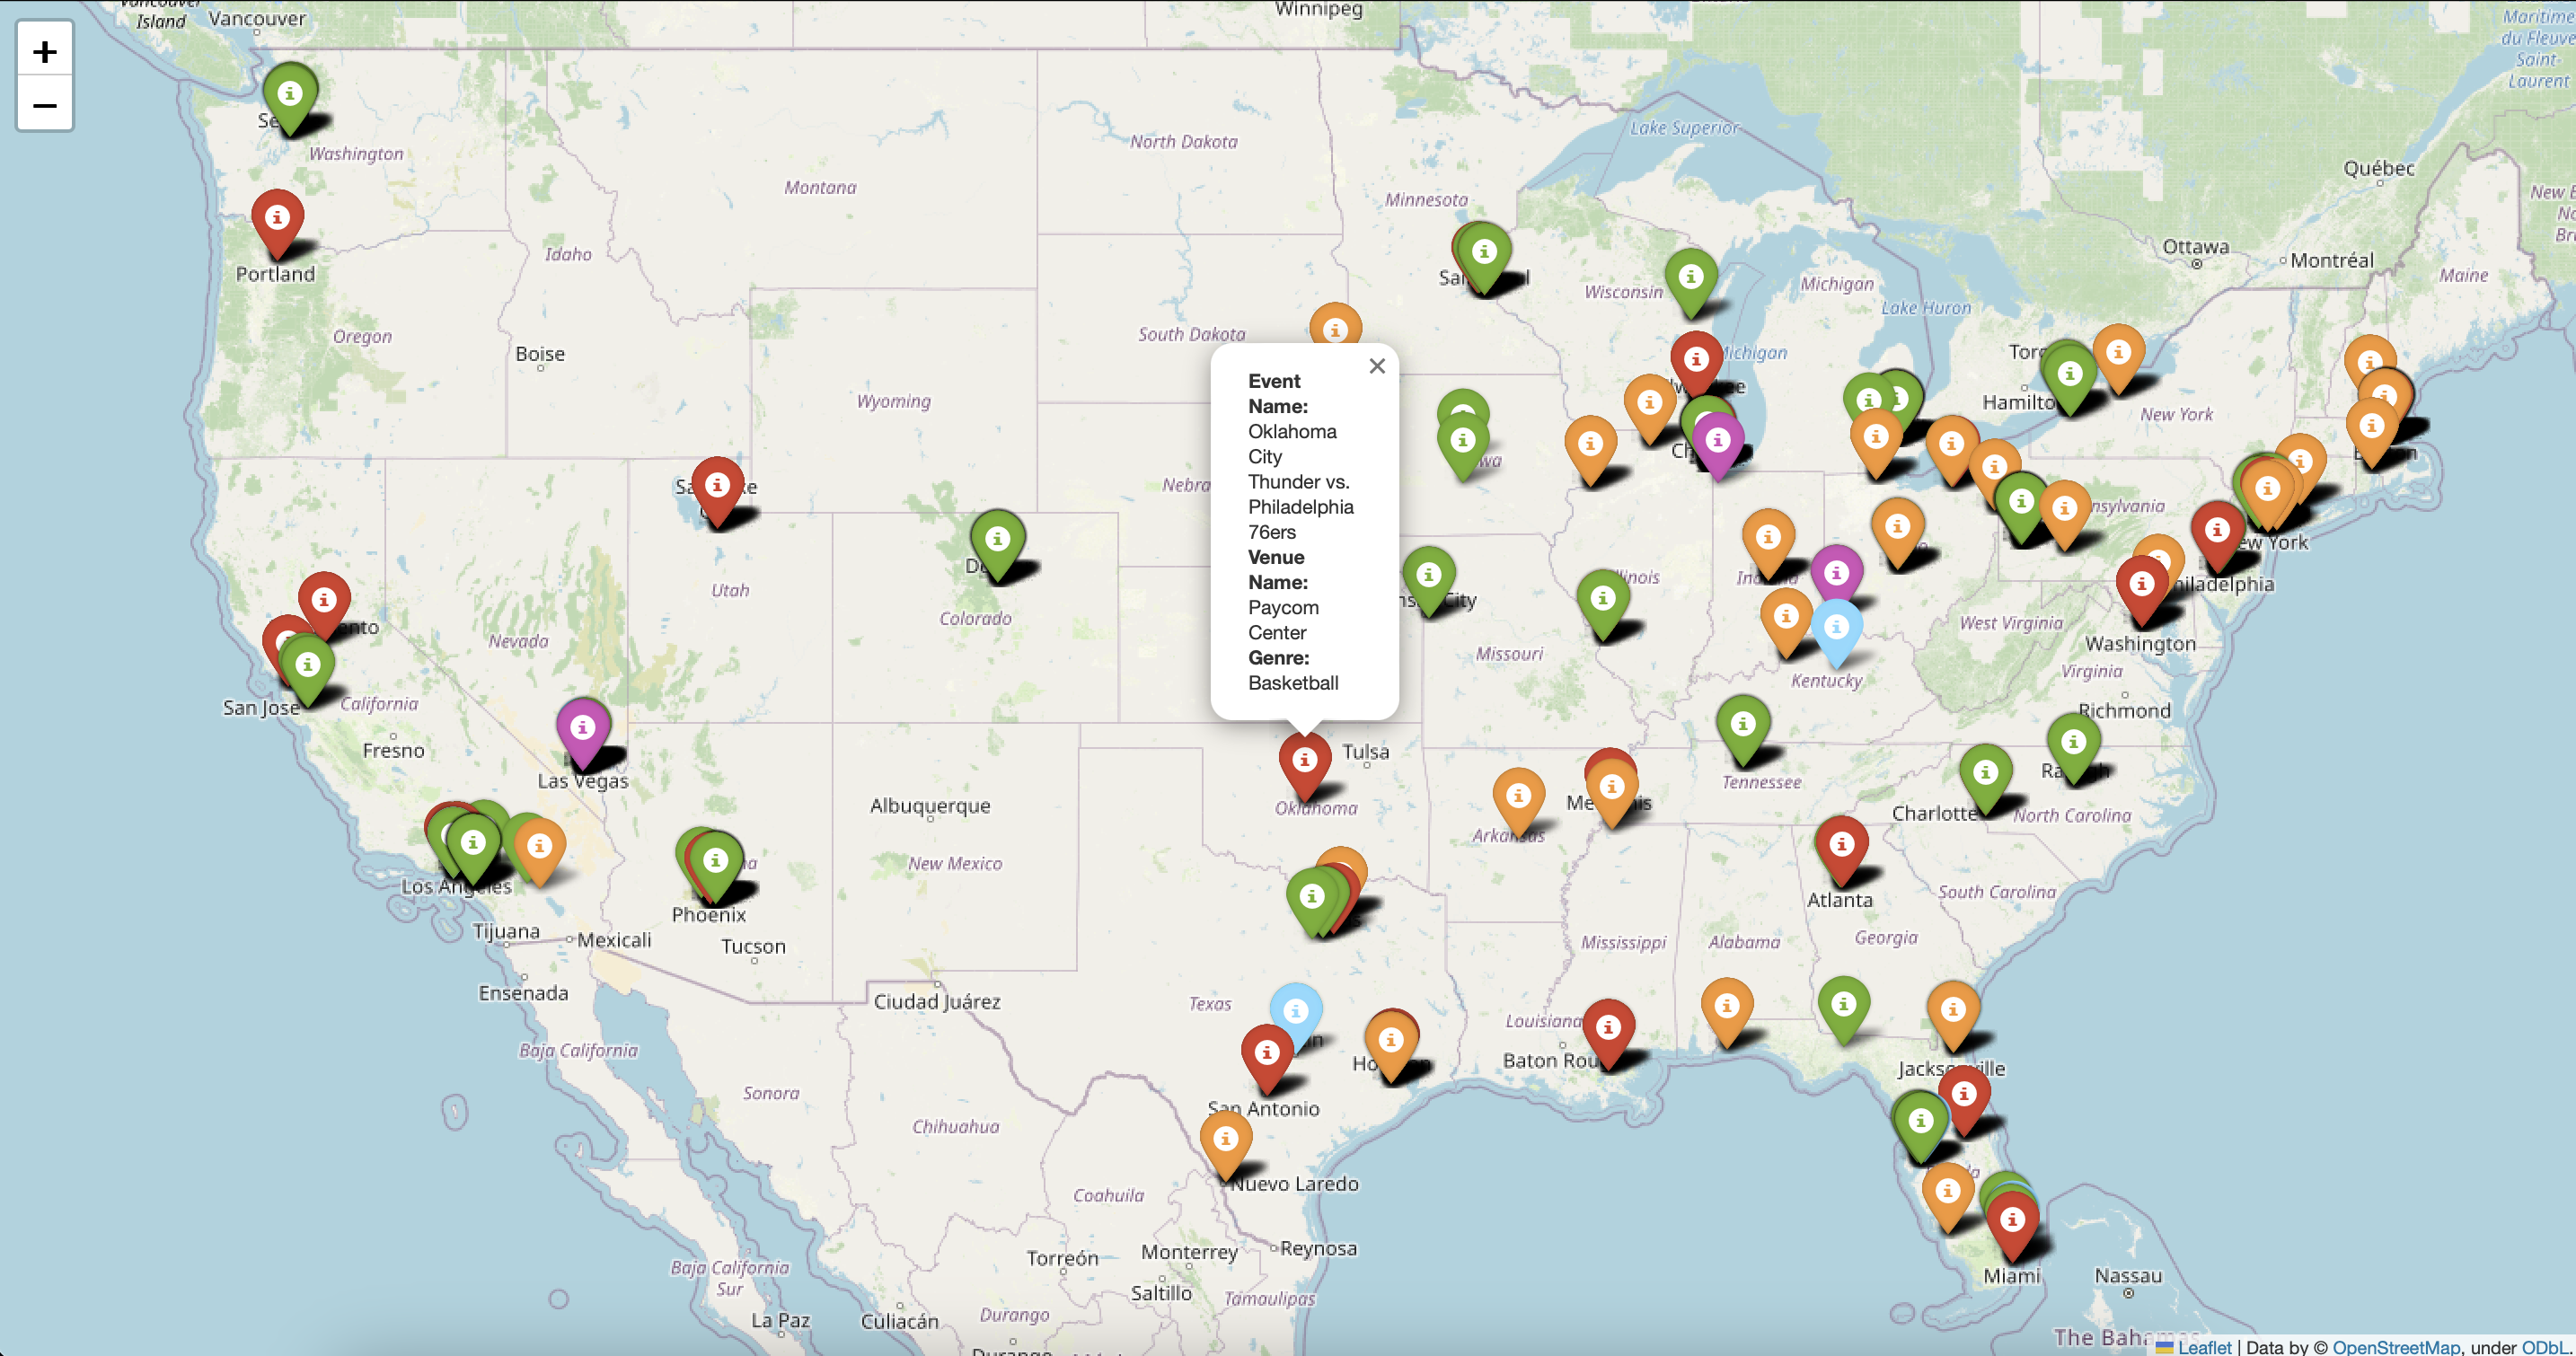

***Summary***

1. The above code generates a colorful map that displays the locations of events. On the map, every event is indicated by a colored dot. 

2. The type and genre of the event determines the spot's color. Events connected to ***music are blue, sports are green, and so on***. 

3. To view information about the event, including its name and location, click on a specific place. 

4. We can browse and explore this map that has been saved as an HTML file. 

## 2 Ticket :

### 2.1. Create a box plot for ticket prices   - Box Plot 

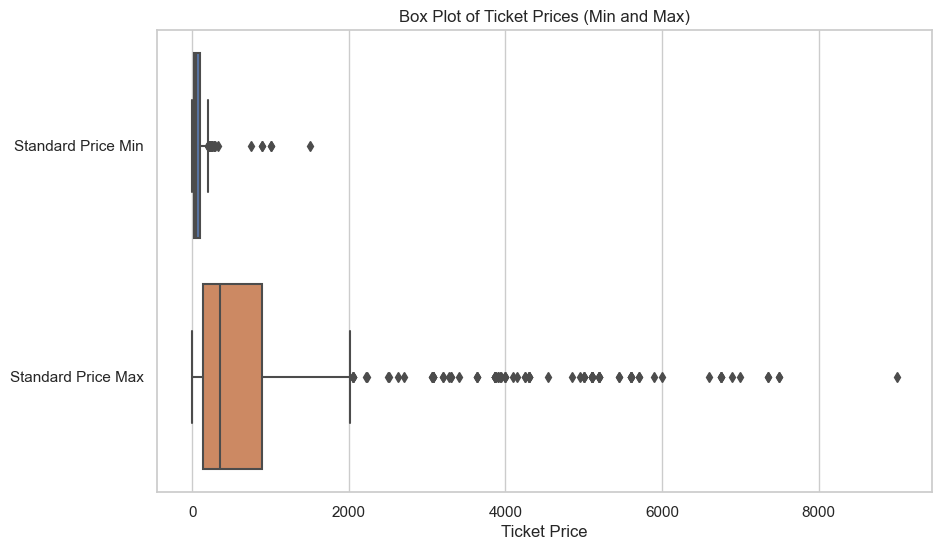

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Standard Price Min', 'Standard Price Max']], orient='h')
plt.xlabel('Ticket Price')
plt.title('Box Plot of Ticket Prices (Min and Max)')
plt.show()

1. Use a box plot to visualize the distribution of ticket prices and identify outliers.
2. Box plots provide information about the median, quartiles, and potential outliers in the data.

***Summary:***

Here we can see that the min and max prices of the tickects with their outliers, from the ticketmaster dataset for the USA Events Ticket Prices. 


### 2.2. Calculate the average ticket prices by segment  - Bar Chart 

In [26]:
average_prices_by_segment = data.groupby('Segment')['Average Price'].mean().reset_index()
fig = px.bar(average_prices_by_segment, x='Segment', y='Average Price',
             title='Average Ticket Prices by Segment',
             labels={'Average Price': 'Average Price'},
             color='Average Price',
             color_continuous_scale='viridis')
fig.update_layout(xaxis_title='Segment', yaxis_title='Average Price', coloraxis_showscale=False)
fig.update_traces(marker_line_color='black', marker_line_width=1)
fig.show()

***Summary:***

Here we anlyse the average cost of tickets for various event segments and creates a bar chart showing the results. 

For the purpose of to help learn pricing variations among the segments, the chart compares the average costs for each segment visually. Seeing the above graph Sport Segment has the highest average price compare to others. 

### 2.3 Group events by  week and  sum of minimum and maximum ticket prices 

In [27]:
event_time_price_trends = data.groupby(data['Event Date'].dt.strftime('%A'))[['Standard Price Min', 'Standard Price Max']].sum().reset_index()
days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sort_order = pd.DataFrame({'Event Date': days_of_week_order})
event_time_price_trends = pd.merge(sort_order, event_time_price_trends, on='Event Date', how='left')

fig = px.bar(event_time_price_trends, x='Event Date', y=['Standard Price Min', 'Standard Price Max'],
             title='Every day Price Trends and Event Time',
             labels={'Standard Price Min': 'Minimum Price', 'Standard Price Max': 'Maximum Price'},
             color_discrete_map={'Minimum Price': 'skyblue', 'Maximum Price': 'lightcoral'})
fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': days_of_week_order})
fig.update_layout(yaxis_title='Overall Events Price Values')
fig.show()

1. Green bars represent the sum of minimum ticket prices for each day of the week.
2. Purple bars represent the sum of maximum ticket prices for the same days.

***Summary:***

This chart offers an understanding of how ticket prices fluctuate throughout the week which helps in identifying trends in the overall cost of tickets by day of the week. It helps us to know which days have the most expensive or least expensive overall ticket pricing for all events.

### 2.4. Ticket limits Vs Count   - Bar Chart

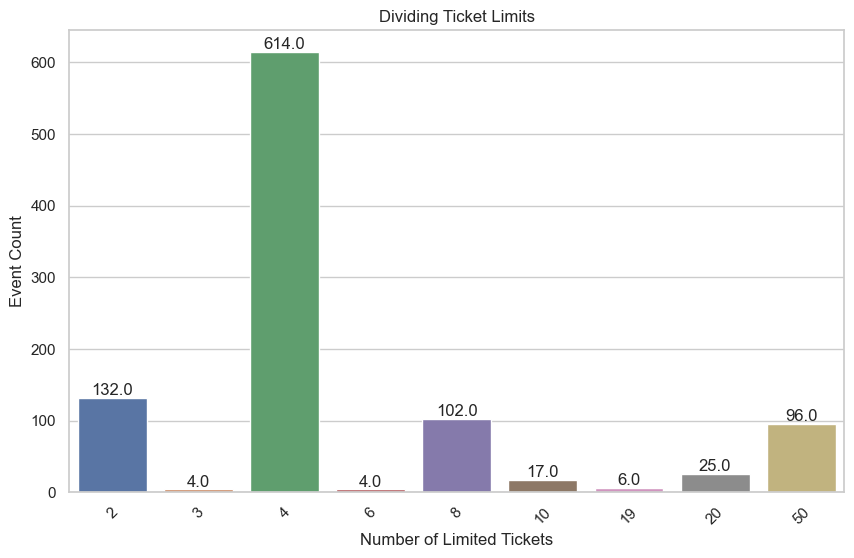

In [28]:
 plt.figure(figsize=(10, 6))
ax = sns.countplot(data=data, x='Ticket Limit')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xlabel('Number of Limited Tickets')
plt.ylabel('Event Count')
plt.title('Dividing Ticket Limits')
plt.xticks(rotation=45)
plt.show()


A bar chart is used to show the dataset, the x-axis shows the various ticket restrictions, and the y-axis indicates the number of events linked to each ticket limit.

***Summary:***

1. The distribution of ticket restrictions through the dataset is clearly shown in the chart. It's simple to see which event ticket limits are more or less common like 3,6,19.


2. Here We can easily find that maximum 626 events has only 4 tickets are availavble for sale and for other shown in the above fig. respectively. 


### 2.5. Compare ticket limits and Events with Segment differentiation    - Heat Map 

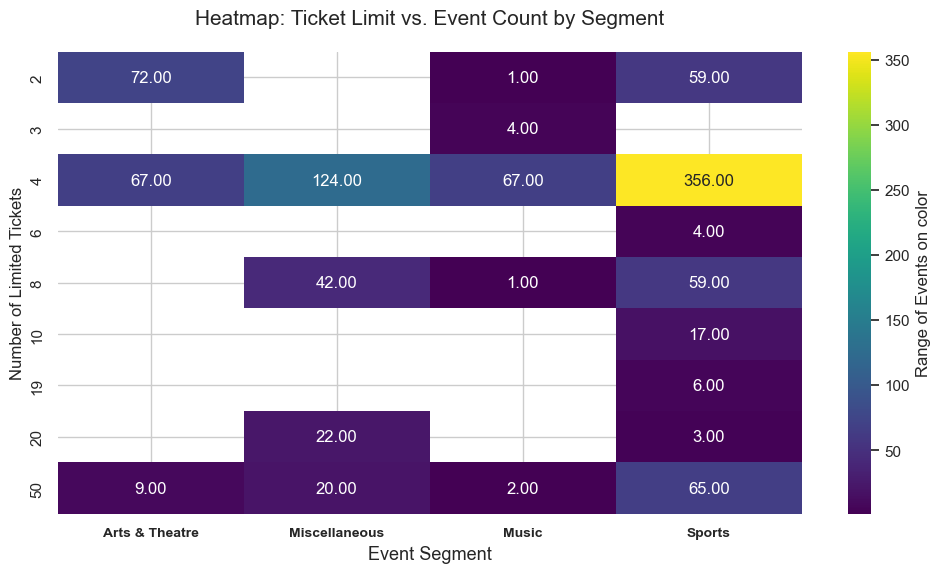

In [29]:
data['Standard Price Min'].fillna(0, inplace=True)
plt.figure(figsize=(12, 6))
heatmap_data = data.pivot_table(values='Standard Price Min', index='Ticket Limit', columns='Segment', aggfunc='count')
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".2f", cbar_kws={'label': 'Range of Events on color'})
plt.xlabel('Event Segment',fontsize=13)
plt.ylabel('Number of Limited Tickets',fontsize=12)
plt.title('Heatmap: Ticket Limit vs. Event Count by Segment',pad=20, fontsize=15)
plt.xticks(fontweight='bold', fontsize=10)
plt.show()

The above Heatmap displays a grid with number of limited tickets (y-axis), event segment (x-axis), and event count represented by each column. Higher counts are represented by more intense colors on the color scale, which displays the number of events.

1. A column represents each of the various segments that make up the x-axis. 

2. Observations within the each squares indicate the precise number of events. 

***Summary:***

This heatmap offers a visual representation of the number of events for various ticket limits and event segments. 

It's clear that there are more events in the "Sports" portion than in the "Music" segment. 

It's a helpful tool for data analysis and visualization since the different color tones make it easy to quickly recognize the event counts in each section.

## 3 Standard Price Min and Max :

### 3.1. Table to compare 'Standard Price Min' and 'Standard Price Max'   - Table

In [30]:
min_price_mean = data['Standard Price Min'].mean()
min_price_median = data['Standard Price Min'].median()
min_price_min = data['Standard Price Min'].min()
min_price_max = data['Standard Price Min'].max()
max_price_mean = data['Standard Price Max'].mean()
max_price_median = data['Standard Price Max'].median()
max_price_min = data['Standard Price Max'].min()
max_price_max = data['Standard Price Max'].max()
summary_data = {
    'Statistic': ['Mean', 'Median', 'Minimum', 'Maximum'],
    'Standard Price Min': [min_price_mean, min_price_median, min_price_min, min_price_max],
    'Standard Price Max': [max_price_mean, max_price_median, max_price_min, max_price_max]
}
table = tabulate(summary_data, headers='keys', tablefmt='fancy_grid')
print(table)

╒═════════════╤══════════════════════╤══════════════════════╕
│ Statistic   │   Standard Price Min │   Standard Price Max │
╞═════════════╪══════════════════════╪══════════════════════╡
│ Mean        │              67.7029 │              837.718 │
├─────────────┼──────────────────────┼──────────────────────┤
│ Median      │              48      │              360     │
├─────────────┼──────────────────────┼──────────────────────┤
│ Minimum     │               0      │                0     │
├─────────────┼──────────────────────┼──────────────────────┤
│ Maximum     │            1500      │             9000     │
╘═════════════╧══════════════════════╧══════════════════════╛


The "Standard Price Min" and "Standard Price Max" categories' summary data are shown in this table:

    1. Mean: The average Standard Price Min is roughly  67.89, while the average Standard Price Max is about 809.86.

    2. Median: The values for Standard Price Min and Standard Price Max are  48, 360 respectively. The center values in the corresponding datasets are represented by this.

    3. Minimum: All events having a cost of 0 are indicated by the minimum values of Standard Price Min and Standard Price Max.

    4. Maximum: The datasets display the highest prices with a maximum of 1,500 for Standard Price Min and a maximum of 9,000 for Standard Price Max.
    
***Suummary:***

Here we analyse taht these data points help in understanding of the dataset's central tendency, distribution, and price range for event tickets.

### 3.2. Comparison 'Standard Price Min' and 'Standard Price Max'   - Scatter plot

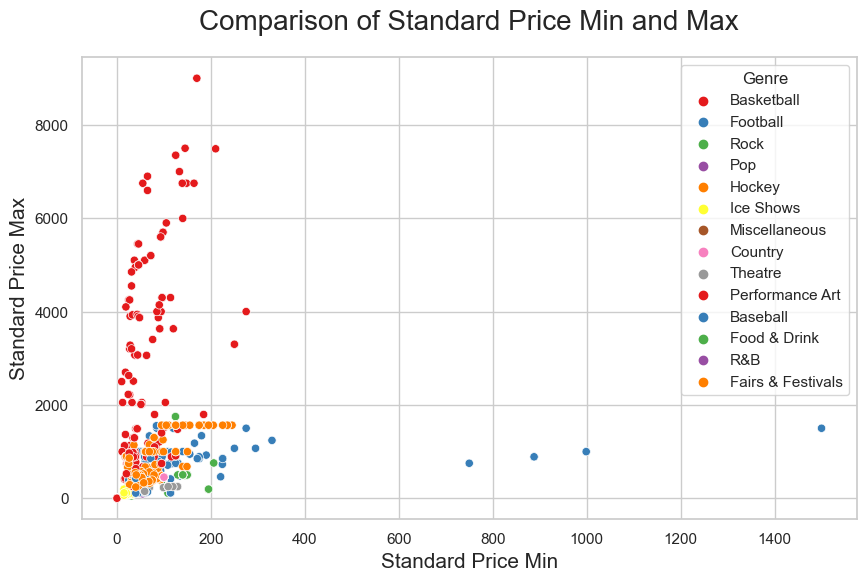

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Standard Price Min', y='Standard Price Max', hue='Genre', palette='Set1')
plt.xlabel('Standard Price Min',fontsize=15)
plt.ylabel('Standard Price Max',fontsize=15)
plt.title('Comparison of Standard Price Min and Max', fontsize=20,pad=20)
plt.show()

***Summary:***

1. The scatter plot above compares the lowest and highest cost of event tickets. 

2. With 'Standard Price Min' on the x-axis and 'Standard Price Max' on the y-axis, each point on the plot represents an event. 

3. We can observe the relationship between these two price categories and how it changes between genres due to the genre-specific color coding of the points.

4. As can be seen, the majority of the data below shows the minimum and maximum prices within the corresponding range of 0-2000.  

This graph helps in the analysis of event pricing ranges and spots any outliers or trends in the relationship between minimum and maximum ticket prices while taking various event genres into consideration.

### 3.3. Calculate the "Standard Price Min" and "Standard Price Max" monthly methods  - Line plot 

In [32]:
data['Event Date'] = pd.to_datetime(data['Event Date'])
price_trends_monthly = data.resample('M', on='Event Date')[['Standard Price Min', 'Standard Price Max']].mean().reset_index()
fig = px.line(price_trends_monthly, x='Event Date', y=['Standard Price Min', 'Standard Price Max'], 
              labels={'value': 'Average Price Min and Max'},
              title='(Monthly) Price Trends Over Time',
              markers=True)
fig.update_xaxes(title_text='Event Date')
fig.update_yaxes(title_text='Average Price')
fig.update_layout(legend_title_text='Price Type')
fig.update_layout(margin=dict(b=10))
fig.show()


# 'Standard Price Max' in descending order  - Tabular data 
top_5_max_prices = price_trends_monthly.sort_values(by='Standard Price Max', ascending=False).head(5)
top_5_max_prices['Event Date'] = top_5_max_prices['Event Date'].dt.strftime('%d-%m-%y')
fig = go.Figure(data=[go.Table(
    header=dict(values=['Event Date', 'Price Min', 'Price Max']),
    cells=dict(values=[top_5_max_prices['Event Date'], 
                       top_5_max_prices['Standard Price Min'].round(2),
                       top_5_max_prices['Standard Price Max'].round(2)]))
])
fig.update_layout(title='Top 5 Records for Standard Price Min and Max by Date')
fig.show()

***Summary:*** 

1. The above line plot provides a broader overview of price patterns. 

2. Tabular data focuses on the particular top five events that have the highest maximum prices and lowest minimun prices, providing a more in-depth analysis of those specific records. 

3. We can easily understand the maximum price for the month of March 2024 is 1448 and the minimum price for the month of April 2024 is 47 based on the facts provided above.  

## 4 Product Information : 

### 4.1. Group events by product and count the number of events for each product - Pie Chart 

In [33]:
filtered_event_product_counts = data[data['Product Type'] != 'Not Available']
event_product_counts = filtered_event_product_counts.groupby(['Product Type'])['Event ID'].count().reset_index()
fig = px.pie(event_product_counts, names='Product Type', values='Event ID', title="Distribution of Product Types with %")
fig.update_traces(textinfo='percent+label', pull=[0.1, 0.1, 0.1, 0.1], textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()


filtered_event_product_counts = data[data['Product Type'] != 'Not Available']
event_product_counts = filtered_event_product_counts.groupby(['Product Name', 'Product Type'])['Event ID'].count().reset_index()
fig = px.sunburst(event_product_counts, path=['Product Type', 'Product Name'], values='Event ID')
fig.update_layout(title="Distribution of Product Types and Names")
fig.show()


1. Pie Chart : 

The distribution of events by product type can be seen in the above design, along with the percentage values of events for each form. Upselling makes up 58.2% of the total, VIP makes up 7.12%, parking makes up 34%, and Special Entry accounts for the remaining portion.

2. Sunburst chart : 

A sunburst chart provides a distribution of products in a hierarchical format. Product names appear in the inner ring, while product types are represented in the outer ring. 
It allows us to examine how events are distributed according to these criteria.

***Summary:*** 

With help of this analysis we can easily find the records of Number of different types of Product and their details accordingly through our datset. 

## 5 Open Hours :   


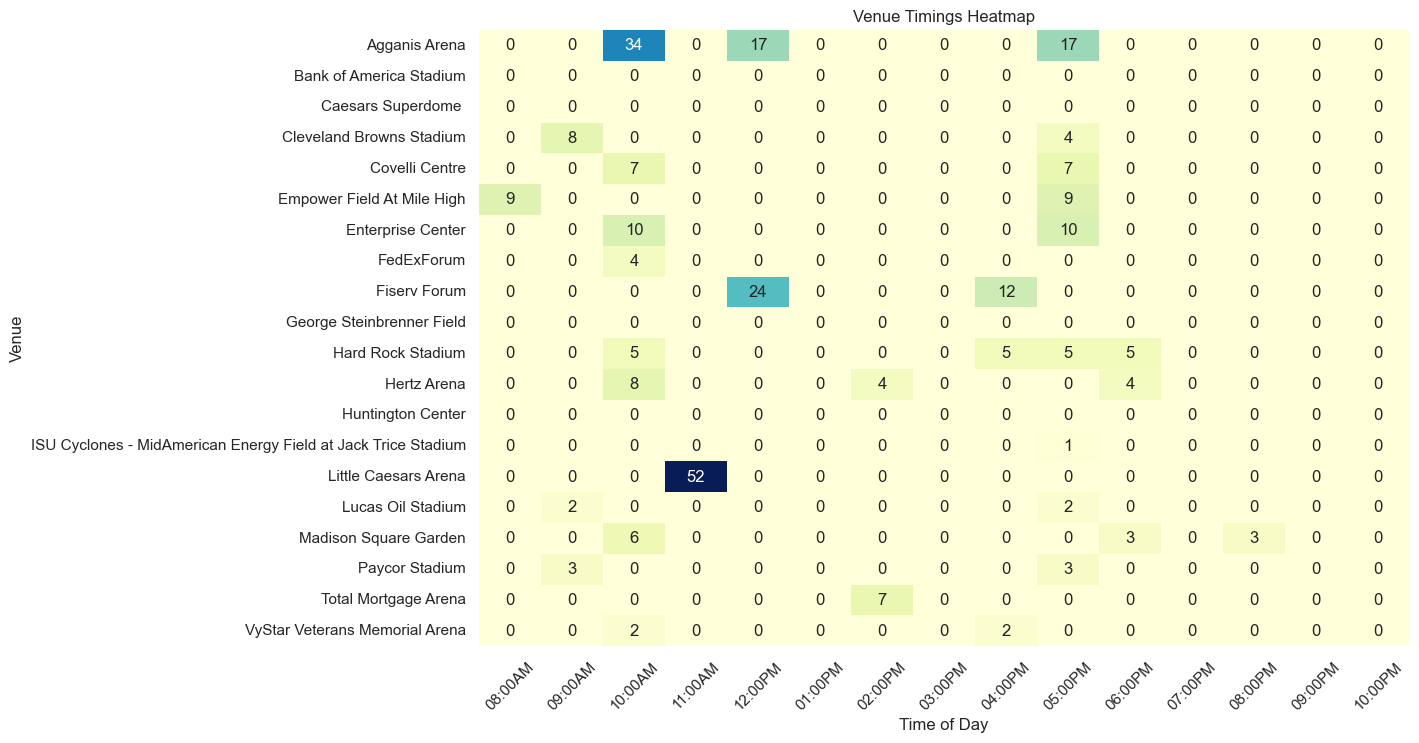

In [34]:
def Ehours(text):
    if pd.isna(text):
        return ['na']
    text = re.sub(r'(\d{1,2})\s*:\s*(\d{2})\s*([ap]*\s*m)', r'\1:\2\3', text, flags=re.I)
    matches = re.findall(r'(\d{1,2}:\d{2}\s*[ap]*\s*m)', text)
    
    if not matches:
        return ['na']
    
    return matches

df = data.groupby('Venue')['Open hours'].agg(lambda x: ' '.join(x)).reset_index()
df['hours_extracted'] = df['Open hours'].apply(Ehours)

dfs = []

for _, row in df.iterrows():
    venue = row['Venue']
    extracted_data = row['hours_extracted']
    
    if extracted_data:
        for match in extracted_data:
            dfs.append(pd.DataFrame({'Venue': [venue], 'time': [match]}))

df_open_hours = pd.concat(dfs, ignore_index=True)
filtered_df = df_open_hours[(df_open_hours['time'] != 'na')].copy()
filtered_df['time'] = pd.to_datetime(filtered_df['time'], format='%I:%M%p')
custom_order = [
                '08:00AM', '09:00AM', '10:00AM', '11:00AM', '12:00PM', '01:00PM',
                '02:00PM', '03:00PM', '04:00PM', '05:00PM', '06:00PM', '07:00PM',
                '08:00PM','09:00PM','10:00PM'
                ]

filtered_df['time'] = pd.Categorical(filtered_df['time'].dt.strftime('%I:%M%p'), categories=custom_order, ordered=True)
filtered_df = filtered_df.sort_values(by='time')

heatmap_data = filtered_df.pivot_table(index='Venue', columns='time', aggfunc='size', fill_value=0)

# Heatmap
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
ax = sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', cbar=False)
plt.title('Venue Timings Heatmap')
plt.xlabel('Time of Day')
plt.ylabel('Venue')
plt.xticks(rotation=45)
plt.show()

1. Extraction of Data:

    A. It extracts time patterns using regular expressions and defines time formats from the 'Open hours' column.

    B. Information about open hours is gathered into a single string and data is categorized per venue.
***
2. Time Allocation:
    
    A. The code generates a DataFrame with venue and time information by extracting time patterns from the combined string for each venue.
    
    B. A datetime format is created from the 'time' column.
***

3. Time Classification:

    A. A defined custom time order is used.
    
    B. This custom order is used to categorize and sort the time values.
    
    
***Summary:***

The above Heatmap gives the information where number of Venues on the Y axis shown and the X axis shown the Timings. 

By Analysing this heatmap we can easily find that maximum offices are opens at 10:00 Am and Closes at 6:00 PM 

# Challenges and Solution 

## 1.  Data Preprocessing 


1. Retrieving data from the Ticketmaster API:

    A. Challenge: 
    
    Because of rate constraints, authentication requirements, and the need for a dependable internet connection, accessing external data via an API can prove difficult.

        example: 
        1. 408 - request time out
        2. 431 - max header size exceed , etc 
    
    B. Solution: 
    
    
      
    Using multiple requests, establishing appropriate authentication, and implementing error-handling code all ways to handle rate constraints.
    
   
 ***  
   
2. Records Cleaning: 

    A. Challenege: 
    
    Facing data retrival in Ticketmaster using API key is very messy task and here require to fill missing values or inconsitent data. 
    
    B. Solution:
    
    To solve missing numbers, inconsistent formats, and outliers, develop data cleaning techniques.
    
***

3. Filling missing values by analysing the application: 

    A. Challenge:
    
    Filling data in the dataset is very tough task, this can affect the data quality from the external Ticketmeaster API, which is very problematic. 
    
    B. Solution:
    
    Here I solved missing numbers, inconsistent formats, and outliers through the  data cleaning techniques. Missing values filled by using methods such as data imputation.
    
    eg: Missing values in Ticket Limit Column 0 
            I analysed the app and filled the 50, ticket limit values instead of 0
            because there is max limit in the app is 50. 
   
***
4. Changing Date Format: 
    
    A. Challenege: 
    
    Event Date-time formats was not in a format that is appropriate for the data analysis. 
      
    B. Solution: 
    
    By using date time conversion I solved the problem using date-time library. 
    
*** 

5. Extra spacing in the data: 

    A. Challenege: 
    
    There are some extra spaces in the city and State column. 
    
    B. Solution: 
    
    By doing the data cleaning using the string split strip i hanndled this challenege. 

***

6. Text Data Cleaning: 

    Apply text data cleaning techniques as needed
    
     For example, remove special characters, convert to lowercase, or perform text normalization
     
     
     
     
*******************



## 2. Data Visualisation 


1. Inconsistent Data: in Open Hours Data Visualisation 

    A.Challenege: 
    
    Open hours data in this dataset is inconsistent, with variations in time formats and missing values. 
    
        1. ex:-  "8 AM" and "08:00 AM" need to be handled.

    B. Solution: 
    
    By using regular expressions and custom formatting to standardize the time data, for cover all possible variationn which required to analyse the data based on the time. 
    

***

2. Visualization Interpretation: 

    A. Challenge 
    
    Creating a heatmap is very challenging, as I have a large amount of data which leads to hard-to-interpret for data visualization.

    B. Solution:
    
    I used filtering and catergorisation as i have mentioned in the code. 
    Using the customize heatmap to visualise the data efficiently using different color palette.  
    
***

3. Selecting right chart:

    A. Challenge: 
       
     It is very difficult to choose the right chart type for the data visualisation. 
     
    B. Solution: 
    
    By understanding the data's characteristics and the information through dataset of "Ticket Master" which I want to convey. 
    
    
      1.1 
      Experiment with different chart types and choose the one that best represents the data and the story.
   
    1.2. 
    Try out several chart styles and select the most accurately depicts the information and the narrative.

*** 

4. Color Selections:

    A. Challenge: 
    
    Misinterpreted or illegible visualizations might result from poor color selections.
    
    B. Solution: 
    
    Choose color schemes that take colorblindness into account, offer enough contrast, and complement the goal of the representation. Here I Used different colors for visualisation. 
    
***

5. Annotations & Labeling:

    A. Challenge: 
    
    Visualizations may become confused due to inadequate labeling and annotations.
    
    B. Solution:
    
    I used headings, labels, and remarks. For, ensure that data points, legends, and axes have sufficient labels to allow for interpretation in the above all data visualisation. 

# Ideas: 

1. Data Transformation:

    We can Convert categorical variables into numerical representations, like one-hot encoding, we can use machine learning models to understand them clearly.

*** 

2. Data Scaling:

    All variables contribute equally to the analysis as we can use normalisation numerical characteristics. 
    
*** 

3. Handling Text Data:

    Text preprocessing techniques such as tokenization and stop-word removal, among many others, should be taken into consideration if we have text data.
    
***


4. Animation of Data:

    To see changes over time, create animations. Time series data can benefit greatly from this.
    
***

5. Colinear Coordinates:

    Parallel coordinate plots are a useful tool for visualizing multivariate patterns and relationships in high-dimensional data.
    
    
***

6. 3D Visualisation: 

    We can represent data in three dimensions with 3D visuals to offer an alternative viewpoint. 
    
***Summary:***

- Creating interactive dashboards, Tableau, Power BI, and open-source programs like Dash is great options for data preprocessing and visualisation together. 

- This methodology provides a relationship between data preparation and visualization to produce meaningful insights and support data-driven decision-making.
   

# Conclusion:


In conclusion, there have been a number of significant issues and good solutions that have occurred during the data preparation and visualization process, especially when handling Ticketmaster API data. These difficulties included inconsistent formats, rate limitations, clumsy data retrieval, and the requirement for precise data interpretation.


- Working with Ticketmaster API data on the USA country on Events, Venues, Tickets, Segments, and many more other data factors helpful to adds the more imapctful knowledge. 


- Which has proven to be a worthwhile educational experience, highlighting the significance of thorough data preparation and efficient data visualization in converting unprocessed data into meaningful insights. Along the way, the path has also highlighted the importance of continuing to strive for excellence in coding and exploring cutting-edge methods to satisfy changing needs in data analysis.
